# Algorithmic Fairness

This is the second in a series of notebooks that make up a [case study on classification and algorithmic fairness](https://allendowney.github.io/RecidivismCaseStudy/).
This case study is part of the [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/) curriculum.
[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/RecidivismCaseStudy/blob/v1/02_calibration.ipynb).

In the previous chapter, we replicated the analysis reported in
"Machine Bias", by Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner, published by ProPublica in May 2016.

After the ProPublica article, the Washington Post published a response by Sam Corbett-Davies, Emma Pierson, Avi Feller and Sharad Goel: "A computer program used for bail and sentencing decisions was labeled biased against Blacks. It’s actually not that clear."

I encourage you to read both of those articles before you go on.  In this chapter, I explain some of the arguments presented in the Washington Post (WaPo) article, and we will replicate their analysis.

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://raw.githubusercontent.com/AllenDowney/RecidivismCaseStudy/v1/rcs_utils.py"
)

## Data

The authors of "Machine Bias" published their data and analysis in [this repository](https://github.com/propublica/compas-analysis).
The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.  The following cell downloads the data file we'll use directly from their repository.

In [2]:
download(
    "https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv"
)

The following cell reads the data file:

In [3]:
import pandas as pd

cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

The dataset includes 7214 rows, one for each defendant, and 53 columns.

## Data bias

[**Note:** I wrote about data bias in the previous notebook, but I am repeating it here in case someone reads this notebook without reading the previous one.]

Systems like COMPAS are trying to predict whether a defendant will *commit* another crime if released.  But the dataset reports whether a defendant was *charged* with another crime.

Not everyone who commits a crime gets charged (not even close).  The probability of getting charged for a particular crime depends on the type of crime and location; the presence of witnesses and their willingness to work with police; the decisions of police about where to patrol, what crimes to investigate, and who to arrest; and decisions of prosecutors about who to charge.

It is likely that every one of these factors depends on the race of the defendant.  In this dataset, the prevalence of *new charges* is higher for Black defendants, but that doesn't necessarily mean that the prevalence of *new crimes* is higher.  

If the dataset is affected by racial bias in the probability of being charged, prediction algorithms like COMPAS will be biased, too.  In discussions of whether and how these systems should be used in the criminal justice system, this is an important issue.  

However, I am going to put it aside *for now* in order to focus on understanding the arguments posed in the ProPublica article and the metrics they are based on.  For the rest of this notebook I will take the "recidivism rates" in the dataset at face value; but I will try to be clear about that they mean (and don't mean).

## The Response

The Washington Post article summarizes the ProPublica article and the response from Northpointe, the company that makes COMPAS, like this:

* ProPublica claims that COMPAS is unfair because "among defendants who ultimately did not reoffend, Blacks were more than twice as likely as Whites to be classified as medium or high risk."

* Northpointe claims that COMPAS is fair because "scores mean essentially the same thing regardless of the defendant’s race. For example, among defendants who scored a seven on the COMPAS scale, 60 percent of White defendants reoffended, which is nearly identical to the 61 percent of Black defendants who reoffended."

So ProPublica and Northpointe are invoking different definitions of "fair".

In the previous chapter we explored the first definition by computing error rates (false positive and false negative) for White and Black defendants.
In this chapter, we'll explore the second definition, which is called "calibration".

## Calibration

The WaPo article includes this figure, which shows "White and Black defendants with the same risk score are roughly equally likely to reoffend."

![](https://raw.githubusercontent.com/AllenDowney/RecidivismCaseStudy/v1/calibration1.png)

To understand this figure, let's start by replicating it.

The following function groups defendants by risk score and computes the fraction in each group that were charged with another crime within two years.

In [4]:
def calibration_curve(df):
    """Fraction in each risk group charged with another crime.

    df: DataFrame

    returns: Series
    """
    grouped = df.groupby("decile_score")
    return grouped["two_year_recid"].mean()

The following figure shows this calibration curve for all defendants and for White and Black defendants separately.

In [5]:
from rcs_utils import decorate, make_matrix, compute_metrics, error_rates

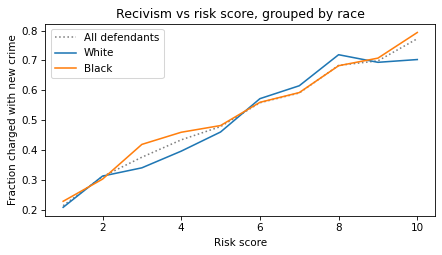

In [6]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle="dotted", color="gray", label="All defendants")

white = cp["race"] == "Caucasian"
cal_white = calibration_curve(cp[white])
cal_white.plot(label="White")

black = cp["race"] == "African-American"
cal_black = calibration_curve(cp[black])
cal_black.plot(label="Black")

decorate(
    xlabel="Risk score",
    ylabel="Fraction charged with new crime",
    title="Recivism vs risk score, grouped by race",
)

This figure shows that people with higher risk scores are more likely to be charged with a new crime within two years.  In that sense COMPAS works as intended.

Furthermore, the test is equally **calibrated** for Black and White defendants; that is, in each risk group, the rate of recidivism is about the same for both groups.

The WaPo article explains why this is important:

> A risk score of seven for Black defendants should mean the same thing as a score of seven for White defendants. Imagine if that were not so, and we systematically assigned Whites higher risk scores than equally risky Black defendants with the goal of mitigating ProPublica’s criticism. We would consider that a violation of the fundamental tenet of equal treatment.

So we want a test that has the same calibration for all groups, and we want a test that has the same error rates for all groups.  But there's the problem: it is mathematically impossible to be fair by both definitions at the same time.

To see why, let's go back to the confusion matrix.

## Matrices and Metrics

In the previous chapter, we computed confusion matrices for White and Black defendants.  Here they are again:

In [7]:
matrix_white = make_matrix(cp[white])
matrix_white

,Pred Positive,Pred Negative
Actual,,
Positive,505,461
Negative,349,1139


In [8]:
matrix_black = make_matrix(cp[black])
matrix_black

,Pred Positive,Pred Negative
Actual,,
Positive,1369,532
Negative,805,990


And here are the metrics we computed from the confusion matrices:

In [9]:
metrics_white = compute_metrics(matrix_white, "White defendants")
metrics_white

,Percent
White defendants,
FPR,23.5
FNR,47.7
PPV,59.1
NPV,71.2
Prevalence,39.4


In [10]:
metrics_black = compute_metrics(matrix_black, "Black defendants")
metrics_black

,Percent
Black defendants,
FPR,44.8
FNR,28.0
PPV,63.0
NPV,65.0
Prevalence,51.4


If we look at the error rates (FPR and FNR), it seems like COMPAS is biased against Black defendants:

* Their false positive rate is higher (45% vs 23%): among people who *will not* recidivate, Black defendants are more likely to be classified high risk.

* Their false negative rate is lower (28% vs 48%): among people who *will* recidivate, Black defendants are less likely to be classified low risk.

But if we look at the the predictive values (PPV and NPV) it seems like COMPAS is biased in favor of Black defendants:

* Among people in the *high risk group*, Black defendants are more likely to be charged with another crime (63% vs 59%).

* Among people in the *low risk group*, Black defendants are less likely to "survive" two years without another charge (65% vs 71%).

It seems like we should be able to fix these problems, but it turns out that we can't.
We'll see why in the next section.

## What Would It Take?

Suppose we want to fix COMPAS so that predictive values are the same for Black and White defendants.  We could do that by using different thresholds for the two groups.
In this section, we'll figure out what it would take to re-calibrate COMPAS; then we'll see what effect that would have on predictive values. 

The following function loops through possible thresholds, makes the confusion matrix with each threshold, and computes accuracy metrics.

In [11]:
def sweep_threshold(cp):
    """Sweep a range of threshold and compute accuracy metrics.

    cp: DataFrame of COMPAS data

    returns: DataFrame with one row for each threshold and
             one column for each metric
    """
    index = range(0, 11)
    columns = ["FPR", "FNR", "PPV", "NPV", "Prevalence"]
    table = pd.DataFrame(index=index, columns=columns, dtype=float)

    for threshold in index:
        m = make_matrix(cp, threshold)
        metrics = compute_metrics(m)
        table.loc[threshold] = metrics["Percent"]

    return table

Here's the resulting table for all defendants.

In [12]:
table_all = sweep_threshold(cp)
table_all.head()

,FPR,FNR,PPV,NPV,Prevalence
0,100.0,0.0,45.1,NaN,45.1
1,71.4,9.5,51.0,78.6,45.1
2,55.1,18.5,54.8,74.8,45.1
3,43.3,27.1,58.0,71.8,45.1
4,32.3,37.4,61.4,68.8,45.1


The following figure shows error rates as a function of threshold.

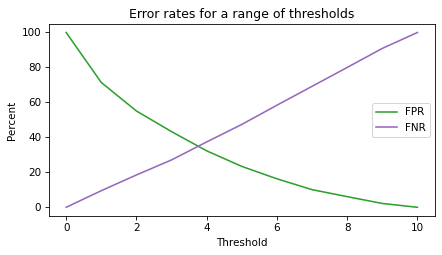

In [13]:
table_all["FPR"].plot(color="C2")
table_all["FNR"].plot(color="C4")

decorate(
    xlabel="Threshold", ylabel="Percent", title="Error rates for a range of thresholds"
)

When the threshold is low, almost everyone is in the high risk group; in that case:

* FNR is low because most recidivists are in the high risk group, but

* FPR is high because most non-recidivists are *also* in the high risk group. 

When the threshold is high, almost everyone is in the low risk group, and the metrics are the other way around:

* FPR is low because most non-recidivists are in the low risk group, but

* FNR is high because most recidivists are *also* in the low risk group.

The following figure shows predictive values for a range of thresholds.

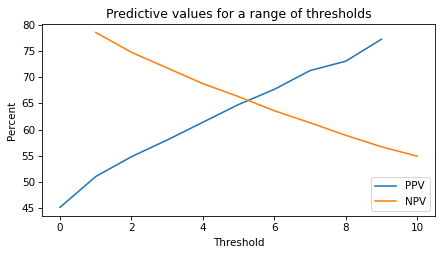

In [14]:
table_all["PPV"].plot(color="C0")
table_all["NPV"].plot(color="C1")

decorate(
    xlabel="Threshold",
    ylabel="Percent",
    title="Predictive values for a range of thresholds",
)

When the threshold is too low, PPV is low.  When the threshold is too high, NPV is low.

Now let's compute tables for Black and White defendants separately.

In [15]:
table_white = sweep_threshold(cp[white])
table_black = sweep_threshold(cp[black])

We'll use the following function to interpolate columns in the table; that is, for a given threshold I can compute the corresponding metric.

In [16]:
from scipy.interpolate import interp1d


def interpolate(series, value, **options):
    """Evaluate a function at a value.

    series: Series
    value: number
    options: passed to interp1d (default is linear interp)

    returns: number
    """
    interp = interp1d(series.index, series.values, **options)
    return interp(value)

The following function goes the other way: it estimates the threshold where a column passes through a given metric.

In [17]:
def crossing(series, value, **options):
    """Find where a function crosses a value.

    series: Series
    value: number
    options: passed to interp1d (default is linear interp)

    returns: number
    """
    interp = interp1d(series.values, series.index, **options)
    return interp(value)

We can use `crossing` to calibrate the test for White defendants; that is, we can compute the threshold that would make the error rates for White defendants the same as for the general population.

In [18]:
matrix_all = make_matrix(cp)
fpr, fnr = error_rates(matrix_all)

In [19]:
crossing(table_white["FPR"], fpr)

array(3.23050171)

In [20]:
crossing(table_white["FNR"], fnr)

array(3.11998938)

With a threshold near 3.2, White defendants would have the same error rates as the general population.
Now let's do the same computation for Black defendants.

In [21]:
crossing(table_black["FPR"], fpr)

array(5.20752868)

In [22]:
crossing(table_black["FNR"], fnr)

array(5.01788384)

To get the same error rates for Black and White defendants, we would need different thresholds: about 5.1 compared to 3.2.
At those levels, the predictive values are substantially different.
Here's PPV with different thresholds for each group:

In [23]:
interpolate(table_white["PPV"], 3.2)

array(55.26)

In [24]:
interpolate(table_black["PPV"], 5.1)

array(66.17)

With equal error rates, we get different PPV:

* Among White defendants in the high risk group, about 55% would recidivate.

* Among Black defendants in the high risk group, about 66% would recidivate.

Here's NPV with different thresholds for each group:

In [25]:
interpolate(table_white["NPV"], 3.2)

array(73.04)

In [26]:
interpolate(table_black["NPV"], 5.1)

array(62.19)

With equal error rates, the NPVs are substantially different:

* Among White defendants in the low risk group, 73% went two years without another charge.

* Among Black defendants in the low risk group, 62% went two years without another charge.

To summarize, if the test is calibrated in terms of error rates, it is not calibrated in terms of predictive values.

* If we make the error rates more equal, we make the predictive values more unfair, and 

* If we make the predictive values more equal, we make the error rates more unfair.

Fundamentally, the problem is that the prevalence of recidivism is different in the two groups: about 39% of White defendants were charged with another crime within two years, compared to 51% of Black defendants.
As long as that's the case (for any two groups) the predictive values and error rates can't be "fair" at the same time.

That's the argument the Washington Post article presented.
In the next section, we'll take the argument one step farther by introducing one more metric, the area under the ROC curve.

## ROC Curve

In the previous section we plotted various metrics as as function of threshold.  Another common and useful way to visualize these results is to plot sensitivity versus false positive rate (FPR).  For historical reasons, the result is called a **receiver operating characteristic (ROC) curve**.

The following function plots the ROC curve:

In [27]:
import matplotlib.pyplot as plt


def plot_roc(table, **options):
    """Plot the ROC curve.

    table: DataFrame of metrics as a function of
           classification threshold
    options: passed to plot
    """
    plt.plot([0, 100], [0, 100], ":", color="gray")
    sens = 100 - table["FNR"]
    plt.plot(table["FPR"], sens, **options)
    decorate(xlabel="FPR", ylabel="Sensitivity (1-FNR)", title="ROC curve")

Here's the ROC curve for all defendants.

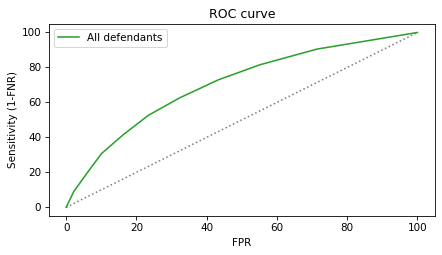

In [28]:
plot_roc(table_all, color="C2", label="All defendants")

The green line is the ROC curve.  The gray dotted line shows the identity line for comparison.

An ideal test would have high sensitivity for all values of FPR, but in reality there is almost always a trade-off:

* When FPR is low, sensitivity is low.  

* In order to get more sensitivity, we have to accept a higher FPR.

The ROC curve tells us how much sensitivity we get for a given FPR or, the other way around, how much FPR we have to accept to achieve a given sensitivity.
The following figure shows the ROC curves for White and Black defendants.

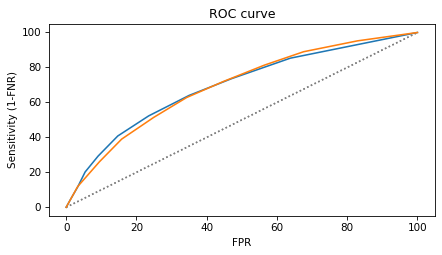

In [29]:
plot_roc(table_white)
plot_roc(table_black)

The ROC curves are similar for the two groups, which shows that we can achieve nearly the same error rates (FPR and FNR) for the two groups, as we did in the previous section.
It also shows that the test has nearly the same "concordance" for both groups, which I explain in the next section.

## Concordance

The authors of the ProPublica article published a supplementary article,
"How We Analyzed the COMPAS Recidivism Algorithm", which describes their analysis in more detail (see <https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm>).

As another metric of accuracy, they estimate **concordance**, which they describe like this:

> Overall, [COMPAS has] a concordance score of 63.6 percent.  That means for any randomly selected pair of defendants in the sample, the COMPAS system can accurately rank their recidivism risk 63.6 percent of the time (e.g. if one person of the pair recidivates, that pair will count as a successful match if that person also had a higher score). In its study, Northpointe reported a slightly higher concordance: 68 percent.

They explain: 

> [These estimates] are lower than what Northpointe describes as a threshold for reliability. "A rule of thumb according to several recent articles is that [concordances] of .70 or above typically indicate satisfactory predictive accuracy, and measures between .60 and .70 suggest low to moderate predictive accuracy," the company says in its study.

There are several ways to compute concordance, but one of the simplest is to compute the area under the ROC curve, which is why concordance is also called the **area under the curve** or AUC.
Since we've already computed the ROC, we can use Simpson's rule to estimate the area under the curve (see <https://en.wikipedia.org/wiki/Simpsons_rule>).

In [30]:
from scipy.integrate import simpson


def compute_auc(table):
    """Compute the area under the ROC curve."""
    y = 100 - table["FNR"]
    x = table["FPR"]
    y = y.sort_index(ascending=False) / 100
    x = x.sort_index(ascending=False) / 100
    return simpson(y=y.values, x=x.values)

The concordance for all respondents is about 70%.

In [31]:
compute_auc(table_all)

0.7061166121516749

For the subgroups it is slightly lower, but also near 70%.

In [32]:
compute_auc(table_white)

0.6996145234049567

In [33]:
compute_auc(table_black)

0.6946519102148443

Different ways of computing concordance handle ties differently, which is probably why we, ProPublica, and Northpointe get somewhat different estimates.
But qualitatively they all tell the same story; as a binary classifier, COMPAS is only moderately accurate. However, it seems to be equally accurate, by this metric, for White and Black defendants.

## Summary

In this chapter, we replicated the analysis reported in the Washington Post article and confirmed two of the arguments they presented:

1. COMPAS is calibrated in the sense that White and Black defendants with the same risk score have almost the same probability of being charged with another crime.  This implies that it has roughly the same predictive value for both groups.

2. It is impossible for COMPAS to have the same predictive values for both groups and the same error rates at the same time.

And we showed:

* If you design a test to achieve equal predictive value across groups with different prevalence, you will find that error rates differ.  Specifically, false positive rates will be higher in groups with higher recividism.

* If you design a test to achieve equal error rates across groups, you will find that predictive values differ.  Specifically, positive predictive value will be lower in groups with lower rates of recidivism.

Finally, we derived the ROC curve and computed AUC, which shows that COMPAS has nearly the same concordance for White and Black defendants.

In [the next notebook](https://colab.research.google.com/github/AllenDowney/RecidivismCaseStudy/blob/v1/03_fairness.ipynb) we'll apply the same analysis to evaluate the performance of COMPAS for male and female defendants.  We'll find that COMPAS is unfair to women, but in a way that's opposite what we have seen so far: the error rates are about the same for both groups, but the predictive values are substantially different.

## Discussion

If it is impossible to make a classification algorithm fair for all groups, what should we do?

It might be tempting to forbid algorithms like COMPAS in the criminal justice system, but unfortunately, that doesn't solve the problem.
The conclusions we reached in this case study apply to human decision-makers as well, with the additional problem that humans are more unpredictable than algorithms, and can be more biased.
As long as we have to make decisions about bail, sentencing, and parole, we will need data and algorithms to inform those decisions, regardless of whether the algorithms are run by humans or machines.

I don't have a solution to these problems, but I will suggest two guidelines: the data we use should be unbiased, and the algorithms should be transparent.

I discussed the problem of data bias in the previous chapter. In this example, we used data about additional *charges* as a measure of additional *crimes*. But not everyone who commits a crime gets charged. If one group is more likely than another to be charged with a crime, the algorithm will be unfair, no matter how it is calibrated.

Of course we should use unbiased data if we can, but if that's not possible, sometimes we can do as well if we *know* the data is biased, in what directions, and by how much.
So one thing we can do to make algorithms more fair is to quantify biases in the data we use and compensate for them.

Another thing we can do is make systems like COMPAS more transparent; that is, we should know how they work, what factors they take into account, and what they ignore.
Algorithms intended to serve the public interest should be the subject of public discussion, not the trade secrets of a private company.

The use of algorithms in criminal justice, and in many other domains that profoundly affect people's lives, is relatively new.
It raises difficult questions about fairness that we have only begun to recognize.

The goal of this case study is to help us measure the accuracy of these algorithms and quantify their fairness. I hope it will contribute to the ongoing debate as we address the many challenges of the criminal justice system and the use of algorithms in our lives.

Recidivism Case Study

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)